<a href="https://colab.research.google.com/github/jufochoa/ML-Geociencias/blob/main/Analisis_BD_Completa_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.PRESENTACION

En el cálculo del transporte de sedimentos a partir de mediciones del campo de flujo se tienen diferentes problemas asociados a: las características del lecho, la disponibilidad del sedimento,además de problemas de escala. Se plantean diferentes preguntas que pueden responderse a partir de datos de mediciones provenientes de ríos y de canales de laboratorio. Los datos usados corresponden a la base de datos presentada por Brownlie (1981), la cual se compone de 7027 datos, donde 1815 mediciones son de ríos naturales y 5212 mediciones en canales de laboratorio. Las variables involucradas en dichas mediciones son:

- Caudal,Q(L/s) - Variable numérica
- Ancho,B (m)   - Variable numérica
- Profundidad de flujo,y (m)  - Variable numérica
- Pendiente del cauce,S(S*1000)  - Variable numérica
- Tamaño medio de los sedimentos del fondo,D50(mm)  - Variable numérica
- Gradación,G (Adim.)  - Variable numérica
- Gravedad específica,Ss(Adim.)  - Variable numérica
- Concentración,C (ppm)  - Variable numérica
- Temperatura, T(C) - Variable numérica
- Forma del Lecho,FL - Variable categórica: 0 - No se observa, 1 - Lecho plano previo a inicio del movimiento, 2 - Rizos, 3 - Dunas, 4 - Lecho en Transición, 5- Lecho plano, 6 Ondas permanenentes, 7- Antidunas,  8 Rápidos y pozos.

Para efectos de conformar los problemas a analizar, la variable para el problema de aprendizaje supervisado será la **Concentración**, mientras que para el problema de aprendizaje no supervisado, se consideran dos variables: un conjunto de datos para la **forma del lecho(FL)** (8 categorías) y un segundo conjunto de datos creando una variable categórica binaria en función de la intensidad del transporte de sedimento según la clasificación propuesta por Gomez & Soar (2020), para lo cual se creó una variable adicional llamada **Tipo** con dos categorías: 1-Transporte ilimitado y 0 - Transporte restringido.

**Este notebook presenta el desarrollo del análisis de modelos supervisados con el conjunto de mediciones total (Laboratorio y Ríos) para la definicion del mejor modelo orientado al cálculo de la Concentración de sedimento**

# 1.ANÁLISIS EXPLORATORIO

In [ ]:
#Instalación de bibliotecas
!pip install scikit-learn
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Cargue de datos al drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cargue de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd

In [ ]:
#Carga de datos
from google.colab import drive
dcrudos=pd.read_excel("/content/drive/MyDrive/ML/BDSedimentos.xlsx")

dcrudos.head(6)
dcrudos.tail(6)

,Medición,Q,B,Y,S,D50,G,Ss,T,FL,C,Nombre,Tipo
7021,31,0.0300,0.5,0.122,1.66,0.18,3.3,2.65,-1.0,3,150.0,ZNA,Laboratorio
7022,32,0.0300,0.5,0.115,1.80,0.18,3.3,2.65,-1.0,3,500.0,ZNA,Laboratorio
7023,33,0.0298,0.5,0.092,3.50,0.18,3.3,2.65,-1.0,6,1007.0,ZNA,Laboratorio
7024,34,0.0304,0.5,0.086,2.07,0.18,3.3,2.65,-1.0,5,1975.0,ZNA,Laboratorio
7025,35,0.0185,0.5,0.040,8.00,0.18,3.3,2.65,-1.0,7,3240.0,ZNA,Laboratorio
7026,36,0.0092,0.5,0.082,2.79,0.18,3.3,2.65,-1.0,3,272.0,ZNA,Laboratorio


In [ ]:
#Resumen estadístico de los datos
pd.set_option('display.width',100)
pd.set_option('precision',3)
dcrudos.describe()

,Medición,Q,B,Y,S,D50,G,Ss,T,FL,C
count,7027.000,7.027e+03,7027.000,7027.000,7027.000,7027.000,7027.00,7027.000,7027.000,7027.000,7027.000
mean,132.922,2.850e+02,38.864,0.791,3.445,1.651,1.54,2.589,13.991,1.669,2065.247
std,168.739,1.700e+03,122.616,1.952,5.135,4.295,2.39,0.287,12.101,2.074,5635.029
min,1.000,3.300e-05,0.070,0.008,-1.000,-10.000,-1.00,1.030,-1.000,0.000,-1.000
25%,25.000,1.505e-02,0.354,0.067,0.820,0.305,1.13,2.650,-1.000,0.000,66.888
50%,70.000,3.877e-02,0.753,0.143,1.500,0.506,1.34,2.650,16.500,0.000,248.000
75%,177.000,6.242e-01,2.438,0.360,4.000,1.349,1.63,2.650,23.000,3.000,1460.500
max,889.000,2.883e+04,1109.472,17.282,162.200,76.113,100.10,4.220,262.000,8.000,111000.000


Se observan valores negativos en las variables **Pendiente(S), D50, Gradación (G), Concentración(C)** y **Temperatura(T)**, que se deben eliminar de la base de datos

In [ ]:
# Conformación de un nuevo conjnto de datos eliminando los valores negativos
dcrudos_F1=dcrudos[(dcrudos["T"]>4)  & (dcrudos["C"]>0) & (dcrudos["G"]>0) & (dcrudos["S"]>0) ]
dcrudos_F1.describe()

,Medición,Q,B,Y,S,D50,G,Ss,T,FL,C
count,4601.000,4.601e+03,4601.000,4601.000,4601.000,4601.000,4601.000,4601.000,4601.000,4601.000,4601.000
mean,92.433,4.077e+02,51.750,0.998,2.135,1.546,1.711,2.564,20.428,1.295,1232.276
std,84.529,2.068e+03,144.970,2.279,3.406,4.105,2.901,0.327,8.661,1.840,5348.060
min,1.000,3.300e-05,0.076,0.009,0.003,0.011,0.405,1.030,4.260,0.000,0.003
25%,22.000,1.622e-02,0.381,0.077,0.720,0.286,1.210,2.650,15.800,0.000,65.000
50%,63.000,5.219e-02,0.819,0.160,1.100,0.620,1.440,2.650,20.800,0.000,183.000
75%,147.000,1.184e+01,35.000,0.506,2.000,1.349,1.750,2.650,25.420,3.000,590.828
max,330.000,2.883e+04,1109.472,17.282,36.700,76.113,100.100,2.700,262.000,7.000,111000.000


Eliminando los valores negativos en toda la base de datos, el tamaño pasa de 7027 filas a 4601, es decir, se pierden 2426 (34,5% de los datos). Por lo que se busca cual es la variable que mas datos negativos tiene, encontrando que es la **Temperatura** y mejor se elimina esta variable de la base de datos.

In [ ]:
#Se elimina la columna de temperatura del conjunto original de datos
bdatos=dcrudos.drop(['T'],axis=1)
bdatos

,Medición,Q,B,Y,S,D50,G,Ss,FL,C,Nombre,Tipo
0,1,0.036,0.305,0.131,2.50,0.105,1.27,2.65,0,6600.0,ABA,Laboratorio
1,2,0.036,0.305,0.140,2.20,0.105,1.27,2.65,0,4300.0,ABA,Laboratorio
2,3,0.028,0.305,0.119,2.30,0.105,1.27,2.65,0,7000.0,ABA,Laboratorio
3,4,0.028,0.305,0.131,1.70,0.105,1.27,2.65,0,4500.0,ABA,Laboratorio
4,5,0.025,0.305,0.119,2.10,0.105,1.27,2.65,0,4700.0,ABA,Laboratorio
...,...,...,...,...,...,...,...,...,...,...,...,...
7022,32,0.030,0.500,0.115,1.80,0.180,3.30,2.65,3,500.0,ZNA,Laboratorio
7023,33,0.030,0.500,0.092,3.50,0.180,3.30,2.65,6,1007.0,ZNA,Laboratorio
7024,34,0.030,0.500,0.086,2.07,0.180,3.30,2.65,5,1975.0,ZNA,Laboratorio
7025,35,0.018,0.500,0.040,8.00,0.180,3.30,2.65,7,3240.0,ZNA,Laboratorio


Se exporta a excel la base de datos par calcular los parametros adimensionales

In [ ]:
bdatos.to_excel('bdatos_fil.xlsx',index=False)

In [ ]:
#Resumen estadístico de los datos originales sin la temperatura
BDF=bdatos[(bdatos["C"]>0) & (bdatos["G"]>0) & (bdatos["S"]>0) ]
BDF.describe()

,Medición,Q,B,Y,S,D50,G,Ss,FL,C
count,6641.000,6.641e+03,6641.000,6641.000,6641.000,6641.000,6641.000,6641.000,6641.000,6641.000
mean,137.721,2.880e+02,37.050,0.740,3.583,1.674,1.598,2.590,1.717,2171.676
std,171.753,1.738e+03,124.111,1.958,5.212,4.253,2.430,0.287,2.098,5776.226
min,1.000,3.300e-05,0.070,0.008,0.003,0.011,0.405,1.030,0.000,0.001
25%,26.000,1.416e-02,0.305,0.065,0.890,0.320,1.150,2.650,0.000,78.300
50%,75.000,3.709e-02,0.736,0.133,1.500,0.536,1.350,2.650,0.000,273.700
75%,185.000,3.834e-01,2.438,0.319,4.299,1.349,1.650,2.650,3.000,1640.000
max,889.000,2.883e+04,1109.472,17.282,162.200,76.113,100.100,4.220,8.000,111000.000


Se pasa entonces a una base de datos con 6641 observaciones, donde se se eliminaron 386 datos(5,5% de los registros originales)

In [ ]:
BDF

,Medición,Q,B,Y,S,D50,G,Ss,FL,C,Nombre,Tipo
0,1,0.036,0.305,0.131,2.50,0.105,1.27,2.65,0,6600.0,ABA,Laboratorio
1,2,0.036,0.305,0.140,2.20,0.105,1.27,2.65,0,4300.0,ABA,Laboratorio
2,3,0.028,0.305,0.119,2.30,0.105,1.27,2.65,0,7000.0,ABA,Laboratorio
3,4,0.028,0.305,0.131,1.70,0.105,1.27,2.65,0,4500.0,ABA,Laboratorio
4,5,0.025,0.305,0.119,2.10,0.105,1.27,2.65,0,4700.0,ABA,Laboratorio
...,...,...,...,...,...,...,...,...,...,...,...,...
7022,32,0.030,0.500,0.115,1.80,0.180,3.30,2.65,3,500.0,ZNA,Laboratorio
7023,33,0.030,0.500,0.092,3.50,0.180,3.30,2.65,6,1007.0,ZNA,Laboratorio
7024,34,0.030,0.500,0.086,2.07,0.180,3.30,2.65,5,1975.0,ZNA,Laboratorio
7025,35,0.018,0.500,0.040,8.00,0.180,3.30,2.65,7,3240.0,ZNA,Laboratorio


In [ ]:
#Base de datos numérica
BDFXY=BDF.drop(['Medición','Tipo','Nombre'],axis='columns')
BDFXY

,Q,B,Y,S,D50,G,Ss,FL,C
0,0.036,0.305,0.131,2.50,0.105,1.27,2.65,0,6600.0
1,0.036,0.305,0.140,2.20,0.105,1.27,2.65,0,4300.0
2,0.028,0.305,0.119,2.30,0.105,1.27,2.65,0,7000.0
3,0.028,0.305,0.131,1.70,0.105,1.27,2.65,0,4500.0
4,0.025,0.305,0.119,2.10,0.105,1.27,2.65,0,4700.0
...,...,...,...,...,...,...,...,...,...
7022,0.030,0.500,0.115,1.80,0.180,3.30,2.65,3,500.0
7023,0.030,0.500,0.092,3.50,0.180,3.30,2.65,6,1007.0
7024,0.030,0.500,0.086,2.07,0.180,3.30,2.65,5,1975.0
7025,0.018,0.500,0.040,8.00,0.180,3.30,2.65,7,3240.0


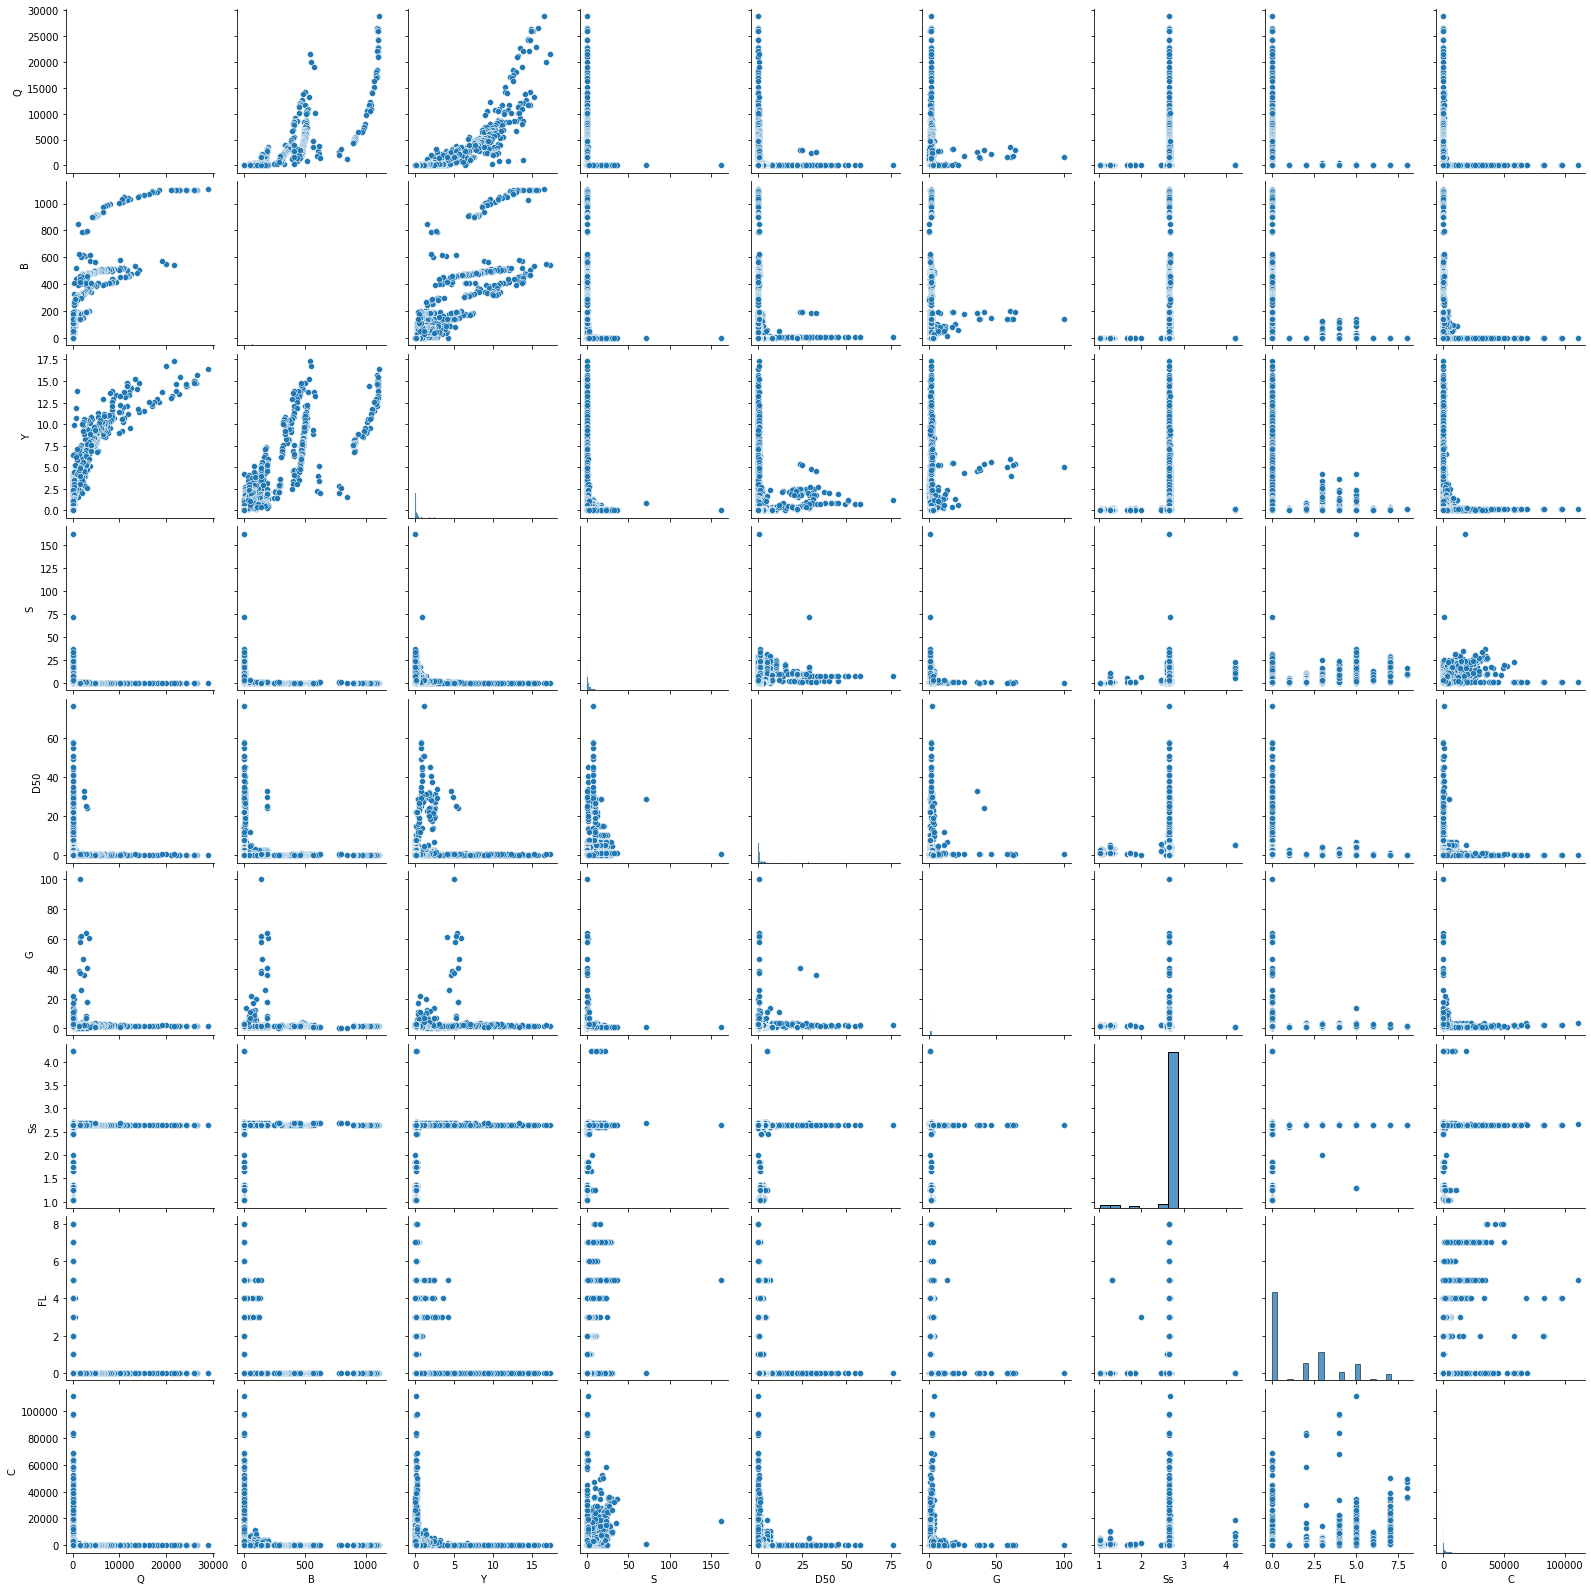

In [ ]:
#Matriz de dispersión - Tarda mucho en producirse

sns.pairplot(BDFXY)

# 2.APRENDIZAJE SUPERVISADO- VARIABLE 'Concentración'

In [ ]:
BDFX=BDF.drop(['Medición','FL','Tipo','C','Nombre','Tipo'],axis='columns')
BDFX

,Q,B,Y,S,D50,G,Ss
0,0.036,0.305,0.131,2.50,0.105,1.27,2.65
1,0.036,0.305,0.140,2.20,0.105,1.27,2.65
2,0.028,0.305,0.119,2.30,0.105,1.27,2.65
3,0.028,0.305,0.131,1.70,0.105,1.27,2.65
4,0.025,0.305,0.119,2.10,0.105,1.27,2.65
...,...,...,...,...,...,...,...
7022,0.030,0.500,0.115,1.80,0.180,3.30,2.65
7023,0.030,0.500,0.092,3.50,0.180,3.30,2.65
7024,0.030,0.500,0.086,2.07,0.180,3.30,2.65
7025,0.018,0.500,0.040,8.00,0.180,3.30,2.65


In [ ]:
BDFY=BDF.filter(['C'])
BDFY

,C
0,6600.0
1,4300.0
2,7000.0
3,4500.0
4,4700.0
...,...
7022,500.0
7023,1007.0
7024,1975.0
7025,3240.0


         Q      B      Y      S    D50      G     Ss     FL      C
Q    1.000  0.834  0.823 -0.110 -0.045  0.063  0.036 -0.135 -0.057
B    0.834  1.000  0.883 -0.186 -0.070  0.081  0.065 -0.232 -0.093
Y    0.823  0.883  1.000 -0.210 -0.027  0.131  0.072 -0.244 -0.109
S   -0.110 -0.186 -0.210  1.000  0.182 -0.078  0.131  0.312  0.467
D50 -0.045 -0.070 -0.027  0.182  1.000  0.027 -0.005 -0.198 -0.078
G    0.063  0.081  0.131 -0.078  0.027  1.000 -0.026 -0.081 -0.024
Ss   0.036  0.065  0.072  0.131 -0.005 -0.026  1.000  0.158  0.057
FL  -0.135 -0.232 -0.244  0.312 -0.198 -0.081  0.158  1.000  0.358
C   -0.057 -0.093 -0.109  0.467 -0.078 -0.024  0.057  0.358  1.000


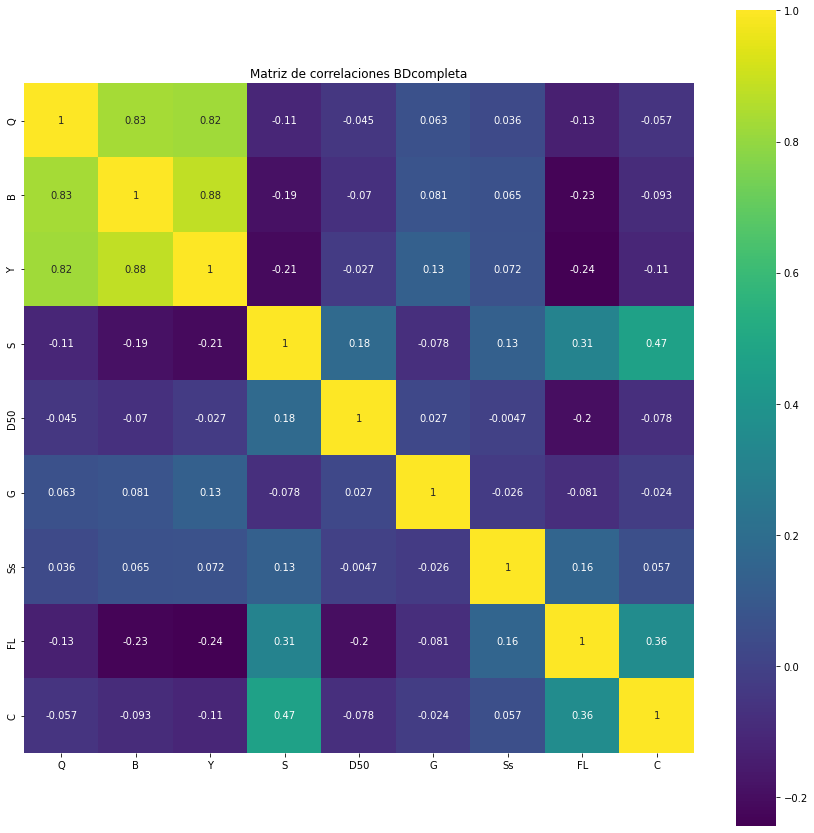

In [ ]:
#Matriz de correlación

corr_BDFXY=BDFXY.corr()
print(corr_BDFXY)
plt.figure(figsize=(15,15))
ax=sns.heatmap(corr_BDFXY,vmax=1,square=True,annot=True,cmap='viridis')
plt.title('Matriz de correlaciones BDcompleta')
plt.savefig("Correlaciones_BDcompleta.jpg")

##  2.1.MODELACION BASE

Se realiza una evaluación de diferentes modelos de clasificación supervisada y se calculan diferentes métricas(r2,MSE,MAE). Finalmente se grafica para comparar

###**2.1.1 Comparación de modelos -Datos base**

###R²

In [ ]:
#Plantilla regresion

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [ ]:
#Resumen parámetros - Resultados 2a
# métrica:R2
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='r2'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFX,BDFY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-290.95%(462.08)
Ridge:-290.93%(462.07)
Lasso:-290.51%(461.80)
ElNet:-263.27%(452.66)
KNR:-345.91%(915.41)
DTR:-808.59%(1,466.32)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-20.73%(27.59)


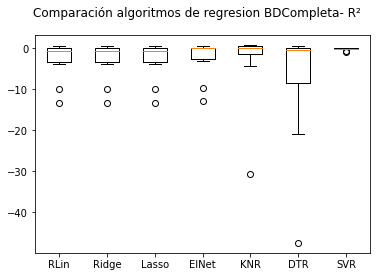

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
#plt.figure(figsize=(20,20))
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDCompleta- R²")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDCompleta- R².jpg")

### Optimización de parámetros (RandomizedSearch)

In [ ]:
# Cargue de bibliotecas para la bùsqueda de hiperparámetros óptimos
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

#Selección del estimador 
estimador_SVR=SVR()

In [ ]:
#Visualización de parámetros del modelo Random Forest
estimador_SVR.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
parametros_busquedaSVR={"C":(0.1,100,1),"gamma":(0.001,10,0.01)}

In [ ]:
busqueda_random=RandomizedSearchCV(estimator=estimador_SVR,
                                   param_distributions=parametros_busquedaSVR,
                                   scoring="r2",n_jobs=-1,n_iter=15)

In [ ]:
busqueda_random.fit(BDFX,BDFY)

In [ ]:
print(busqueda_random.best_score_)
print(busqueda_random.best_estimator_)
print(busqueda_random.best_params_)

0.17919270006093624
SVR(C=100, gamma=0.01)
{'gamma': 0.01, 'C': 100}


In [ ]:
#Orden de resultados
pd.DataFrame(busqueda_random.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,3.558,0.438,0.786,0.011,0.01,100,"{'gamma': 0.01, 'C': 100}",0.476,0.015,-0.087,0.279,0.214,0.179,0.199,1
3,3.159,0.031,0.786,0.012,0.001,100,"{'gamma': 0.001, 'C': 100}",0.324,-0.058,-0.003,0.265,0.321,0.170,0.166,2
4,3.255,0.050,0.781,0.010,10,100,"{'gamma': 10, 'C': 100}",-0.124,-0.207,0.020,-0.017,0.027,-0.060,0.091,3
8,3.014,0.450,0.717,0.142,0.01,1,"{'gamma': 0.01, 'C': 1}",-0.175,-0.227,0.037,-0.063,-0.012,-0.088,0.099,4
6,3.193,0.037,0.787,0.010,0.001,1,"{'gamma': 0.001, 'C': 1}",-0.217,-0.239,0.003,-0.109,-0.010,-0.114,0.101,5
2,3.497,0.294,0.797,0.010,0.01,0.1,"{'gamma': 0.01, 'C': 0.1}",-0.235,-0.244,-0.017,-0.118,-0.029,-0.129,0.097,6
7,3.369,0.374,1.010,0.287,10,1,"{'gamma': 10, 'C': 1}",-0.240,-0.244,-0.023,-0.122,-0.031,-0.132,0.096,7
0,3.348,0.168,0.788,0.021,0.001,0.1,"{'gamma': 0.001, 'C': 0.1}",-0.240,-0.245,-0.023,-0.126,-0.030,-0.133,0.097,8
1,3.064,0.026,0.792,0.011,10,0.1,"{'gamma': 10, 'C': 0.1}",-0.243,-0.246,-0.026,-0.125,-0.032,-0.134,0.096,9


###MSE

In [ ]:
#Resumen parámetros
# métrica:MSE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_squared_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFX,BDFY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-2,969,667,919.10%(5,167,528,621.49)
Ridge:-2,969,523,331.08%(5,167,536,565.42)
Lasso:-2,967,589,896.56%(5,167,684,174.77)
ElNet:-2,805,722,189.36%(5,204,181,682.20)
KNR:-2,325,186,644.93%(4,926,968,584.20)
DTR:-3,112,259,524.58%(4,802,494,353.92)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-3,701,824,893.15%(6,168,597,823.65)


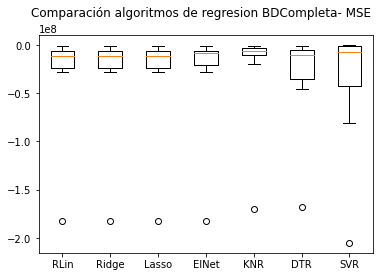

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDCompleta- MSE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDCompleta- MSE.jpg")

###MAE

In [ ]:
#Resumen parámetros
# métrica: MAE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_absolute_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFX,BDFY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-209,912.04%(107,326.95)
Ridge:-209,904.86%(107,334.40)
Lasso:-209,637.89%(107,610.61)
ElNet:-206,596.28%(109,002.60)
KNR:-135,727.41%(99,608.09)
DTR:-163,362.29%(114,217.28)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-208,702.85%(210,622.25)


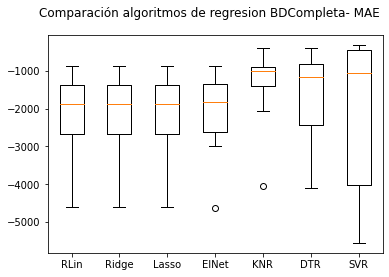

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDCompleta- MAE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDCompleta- MAE.jpg")

### 2.1.2 Feature selection

### Arboles de decision

In [ ]:
# Arboles de decisión
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#Generar la partición
X_train, X_test, Y_train, Y_test = train_test_split(BDFX,BDFY, test_size=0.33, random_state=7)
depth=4
tree=DecisionTreeRegressor(criterion='mse',max_depth=depth)
tree.fit(X_train,Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


DecisionTreeRegressor(criterion='mse', max_depth=4)

In [ ]:
subset=np.unique(tree.tree_.feature[tree.tree_.feature>=0])
print(f"Variables:{BDFX.shape[1]}")
print(f"Variables utilizadas:{subset}")
print(f"Training: {tree.score(X_train,Y_train).round(2)}")
print(f"Test: {tree.score(X_test,Y_test).round(2)}")


Variables:7
Variables utilizadas:[1 3 4 5]
Training: 0.79
Test: 0.72


In [ ]:
print(BDFX.columns[1],BDFX.columns[3],BDFX.columns[4],BDFX.columns[5])

B S D50 G


Se tiene que las variables recomendadas según el método de árboles de decisión corresponden a: ancho(**B**) la pendiente(**S**) y el tamaño medio del material(**D50**) y el coeficiente de gradación(**G**).


In [ ]:
print(BDFX)

          Q      B      Y     S    D50     G    Ss
0     0.036  0.305  0.131  2.50  0.105  1.27  2.65
1     0.036  0.305  0.140  2.20  0.105  1.27  2.65
2     0.028  0.305  0.119  2.30  0.105  1.27  2.65
3     0.028  0.305  0.131  1.70  0.105  1.27  2.65
4     0.025  0.305  0.119  2.10  0.105  1.27  2.65
...     ...    ...    ...   ...    ...   ...   ...
7022  0.030  0.500  0.115  1.80  0.180  3.30  2.65
7023  0.030  0.500  0.092  3.50  0.180  3.30  2.65
7024  0.030  0.500  0.086  2.07  0.180  3.30  2.65
7025  0.018  0.500  0.040  8.00  0.180  3.30  2.65
7026  0.009  0.500  0.082  2.79  0.180  3.30  2.65

[6641 rows x 7 columns]


###Eliminación Backward

In [ ]:
import statsmodels.api as sm

BDFX_1=sm.add_constant(BDFX) #Se agrega la constante como requisito de la técnica
model=sm.OLS(BDFY,BDFX_1).fit()
model.pvalues
# una variable con p mayor a 0.05 es candidata a eliminarse pues no añade información al modelo

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const    9.903e-02
Q        9.872e-01
B        5.132e-01
Y        8.630e-01
S        0.000e+00
D50      4.250e-54
G        7.219e-02
Ss       4.724e-01
dtype: float64

Por tanto, según el método de eliminación Backward, las variables que mas añaden información al modelo son **S** y **D50**.

### Eliminación recursiva de características

In [ ]:
# Para aplicar la regresión logística se requiere e Label encoder para cambiar el dominio de la variables 0-1.
from sklearn import preprocessing
from sklearn import utils

lab = preprocessing.LabelEncoder()
BDFY_t = lab.fit_transform(BDFY)

#view transformed values
print(BDFY_t)

[4242 4093 4266 ... 3746 3969 2429]


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Eliminación recursiva de características
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model=LogisticRegression(solver='lbfgs',max_iter=1000)
rfe=RFE(model,n_features_to_select=4)  # dar prioridad a 4 variables
fit=rfe.fit(BDFX,BDFY_t)

print(list(BDFX.columns))
print(f"Numero de  variables: {fit.n_features_}")
print(f"Variables seleccionadas: {fit.support_}")
print(f"Ranking de variables: {fit.ranking_}")

# Tarda mucho en aplicarse

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

['Q', 'B', 'Y', 'S', 'D50', 'G', 'Ss']
Numero de  variables: 4
Variables seleccionadas: [ True  True False  True  True False False]
Ranking de variables: [1 1 4 1 1 3 2]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Según el método de eliminaciòn recursiva de características, las variables que ma añaden información al modelo son: **Q**,**B**,**S** y **D50**.

## 2.2 MODELACION CON REDUCCION DE VARIABLES

Las variables seleccionadas para evaluar los modelos son: **Q**,**B**,**S** y **D50**.

In [ ]:
BDFX

,Q,B,S,D50
0,0.036,0.305,2.50,0.105
1,0.036,0.305,2.20,0.105
2,0.028,0.305,2.30,0.105
3,0.028,0.305,1.70,0.105
4,0.025,0.305,2.10,0.105
...,...,...,...,...
7022,0.030,0.500,1.80,0.180
7023,0.030,0.500,3.50,0.180
7024,0.030,0.500,2.07,0.180
7025,0.018,0.500,8.00,0.180


In [ ]:
BDFX=BDF.drop(['Medición','G','Y','Ss','C','FL','Tipo','Nombre'],axis='columns')
BDFX

,Q,B,S,D50
0,0.036,0.305,2.50,0.105
1,0.036,0.305,2.20,0.105
2,0.028,0.305,2.30,0.105
3,0.028,0.305,1.70,0.105
4,0.025,0.305,2.10,0.105
...,...,...,...,...
7022,0.030,0.500,1.80,0.180
7023,0.030,0.500,3.50,0.180
7024,0.030,0.500,2.07,0.180
7025,0.018,0.500,8.00,0.180


In [ ]:
BDFY

,C
0,6600.0
1,4300.0
2,7000.0
3,4500.0
4,4700.0
...,...
7022,500.0
7023,1007.0
7024,1975.0
7025,3240.0


### 2.2.1 Comparación de modelos - Datos reducidos

###R²

In [ ]:
#Resumen parámetros - - Resultados 2b
# métrica_R²
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='r2'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFX,BDFY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-271.40%(464.83)
Ridge:-271.39%(464.83)
Lasso:-271.34%(464.78)
ElNet:-258.27%(452.60)
KNR:-50.86%(142.38)
DTR:-245.56%(499.08)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-20.73%(27.59)


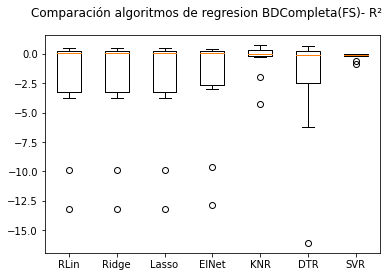

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDCompleta(FS)- R²")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDCompleta(FS)- R².jpg")

###MSE

In [ ]:
#Resumen parámetros
# métrica:_MSE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_squared_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFX,BDFY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-2,797,908,041.78%(5,204,103,102.34)
Ridge:-2,797,895,763.42%(5,204,107,538.86)
Lasso:-2,797,774,077.94%(5,204,170,492.64)
ElNet:-2,766,118,271.99%(5,217,036,639.32)
KNR:-2,377,116,422.68%(4,933,133,115.27)
DTR:-2,605,347,624.32%(4,630,231,942.21)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-3,701,815,629.20%(6,168,582,165.35)


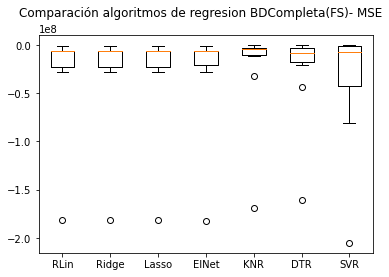

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDCompleta(FS)- MSE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDCompleta(FS)- MSE.jpg")

###MAE

In [ ]:
#Resumen parámetros
# métrica:MAE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_absolute_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFX,BDFY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-205,371.80%(109,448.24)
Ridge:-205,371.54%(109,448.31)
Lasso:-205,368.03%(109,450.50)
ElNet:-204,784.69%(109,741.66)
KNR:-141,024.43%(107,435.70)
DTR:-161,196.61%(110,309.73)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-208,702.49%(210,621.69)


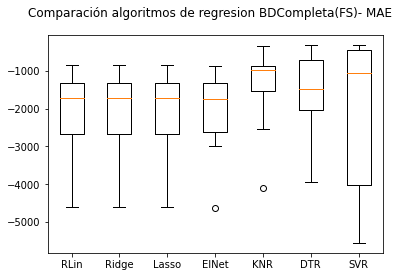

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDCompleta(FS)- MAE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDCompleta(FS)- MAE.jpg")

## 2.3 MODELACIÓN CON VARIABLES ESCALADAS

In [ ]:
BDFX.describe()

,Q,B,S,D50
count,6.641e+03,6641.000,6641.000,6641.000
mean,2.880e+02,37.050,3.583,1.674
std,1.738e+03,124.111,5.212,4.253
min,3.300e-05,0.070,0.003,0.011
25%,1.416e-02,0.305,0.890,0.320
50%,3.709e-02,0.736,1.500,0.536
75%,3.834e-01,2.438,4.299,1.349
max,2.883e+04,1109.472,162.200,76.113


###Escalamiento

In [ ]:
#escalamiento de la X a valores entre 0 y 1

#from sklearn.preprocessing import MinMaxScaler
#scaler=MinMaxScaler(feature_range=(0,1))
#rescaledX=scaler.fit_transform(BDFX)
#np.set_printoptions(precision=3)
#print(rescaledX[0:5,:])

#estandarización de la X con media 0 y desviacion de 1
#from sklearn.preprocessing import StandardScaler
#scaler=StandardScaler().fit(BDFX)
#rescaledX=scaler.fit_transform(BDFX)
#np.set_printoptions(precision=3)
#print(rescaledX[0:5,:])

#normalizacion de la X a valores entre 0 y 1
from sklearn.preprocessing import Normalizer
scaler=Normalizer().fit(BDFX)
rescaledX=scaler.transform(BDFX)
np.set_printoptions(precision=3)
print(rescaledX[0:5,:])

[[0.014 0.121 0.992 0.042]
 [0.016 0.137 0.989 0.047]
 [0.012 0.131 0.99  0.045]
 [0.016 0.176 0.982 0.061]
 [0.012 0.144 0.988 0.049]]


In [ ]:
rescaledX

array([[0.014, 0.121, 0.992, 0.042],
       [0.016, 0.137, 0.989, 0.047],
       [0.012, 0.131, 0.99 , 0.045],
       ...,
       [0.014, 0.234, 0.968, 0.084],
       [0.002, 0.062, 0.998, 0.022],
       [0.003, 0.176, 0.982, 0.063]])

### 2.3.1 Comparacion de modelos - Datos reducidos y reescalados

###R²

In [ ]:
#Resumen parámetros - - Resultados 2c
# métrica: r2,neg_mean_squared_error,neg_mean_absolute_error,
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='r2'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,rescaledX,BDFY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-185.90%(272.58)
Ridge:-185.02%(271.98)
Lasso:-185.76%(272.31)
ElNet:-229.67%(340.84)
KNR:-35.55%(98.75)
DTR:-17.42%(66.07)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-12.69%(27.01)


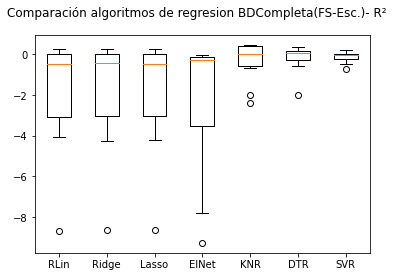

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDCompleta(FS-Esc.)- R²")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDCompleta(FS-Esc.)- R².jpg")

###MSE

In [ ]:
#Resumen parámetros
# métrica: MSE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_squared_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,rescaledX,BDFY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-2,823,966,557.81%(5,070,069,553.86)
Ridge:-2,822,667,612.52%(5,071,005,895.70)
Lasso:-2,824,013,320.54%(5,070,222,157.91)
ElNet:-3,269,414,997.67%(5,490,742,480.92)
KNR:-2,402,923,105.18%(4,937,197,868.57)
DTR:-2,279,287,803.53%(3,967,390,494.01)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-3,541,714,993.52%(6,029,021,988.23)


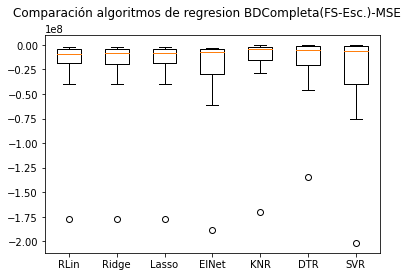

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDCompleta(FS-Esc.)-MSE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDCompleta(FS-Esc.)-MSE.jpg")

###MAE

In [ ]:
#Resumen parámetros
# métrica: MAE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_absolute_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,rescaledX,BDFY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-247,808.45%(120,981.75)
Ridge:-247,239.75%(120,896.01)
Lasso:-247,582.52%(120,862.73)
ElNet:-273,875.64%(131,080.41)
KNR:-156,072.27%(128,238.04)
DTR:-162,674.20%(144,057.36)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-197,538.17%(199,310.69)


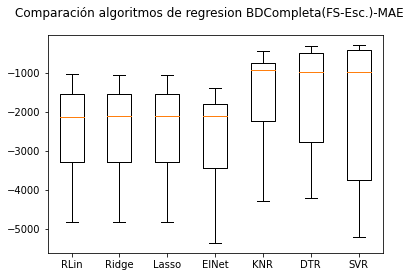

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDCompleta(FS-Esc.)-MAE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDCompleta(FS-Esc.)-MAE.jpg")

##2.4 MODELACION CON VARIABLES ADIMENSIONALES

Se adimensionalizan las variables buscando un modelo con mejor ajuste, incluyendo un parámetro para la concentración

In [ ]:
# Cálculo de la nueva matriz de variables
BDFA= pd.DataFrame()

nu=1e-6 # Viscosidad cinematica del agua
BDFA['AA']=BDF['B']/(BDF['D50']/1000)
BDFA['PA']=BDF['Y']/(BDF['D50']/1000)
BDFA['Ref']=BDF['Q']/(BDF['B']*nu)
BDFA['Res']=(BDF['D50']/1000)*pow(9.81*BDF['Y']*BDF['S']/1000,0.5)/(nu)
BDFA['EA']=BDF['Y']*(BDF['S']/1000)/((BDF['D50']/1000)*(BDF['Ss']-1))
BDFA['Ff']=BDF['Q']/(BDF['B']*pow(9.81*BDF['Y']**3*BDF['S']/1000,0.5))
BDFA['Fr']=BDF['Q']/(BDF['B']*pow(9.81*BDF['Y']**3,0.5))
BDFA['CUA']=BDF['Q']/(BDF['B']*(BDF['D50']/1000)*pow(9.81*BDF['Y']*BDF['S']/1000,0.5))
BDFA['VCA']=nu*pow(9.81*BDF['Y']*BDF['S']/1000,0.5)/(9.81*(BDF['Ss']-1)*(BDF['D50']/1000)**2)
BDFA['TPA']=pow(nu,2)/(9.81*(BDF['Ss']-1)*(BDF['D50']/1000)**3)
BDFA['CUA2']=BDF['Q']**2/(BDF['B']**2*9.81*(BDF['Ss']-1)*(BDF['D50']/1000)**3)
BDFA['PM']=BDF['Y']*(BDF['S']/1000)/(BDF['D50']/1000)
BDFA['Frp']=BDF['Q']/(BDF['B']*BDF['Y']*pow(9.81*(BDF['Ss']-1)*BDF['D50']/1000,0.5))
BDFA['Phi']=BDF['C']*(BDF['D50']/1000)*BDF['Q']/(BDF['B']*BDF['Y']*pow(9.81*(BDF['Ss']-1)*(BDF['D50']/1000)**3,0.5))
BDFA

,AA,PA,Ref,Res,EA,Ff,Fr,CUA,VCA,TPA,CUA2,PM,Frp,Phi
0,2904.762,1248.571,116570.492,5.954,1.892,15.681,0.784,19579.134,0.318,0.053,7.252e+08,3.121,21.568,142350.418
1,2904.762,1335.238,117442.623,5.776,1.780,15.229,0.714,20333.708,0.308,0.053,7.361e+08,2.938,20.319,87372.560
2,2904.762,1132.381,93052.459,5.438,1.578,15.110,0.725,17109.968,0.290,0.053,4.621e+08,2.604,18.983,132884.068
3,2904.762,1248.571,90219.672,4.910,1.286,14.718,0.607,18376.028,0.262,0.053,4.344e+08,2.123,16.693,75117.295
4,2904.762,1132.381,81465.574,5.197,1.441,13.844,0.634,15676.523,0.277,0.053,3.542e+08,2.378,16.620,78112.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,2777.778,638.889,60000.000,8.111,0.697,11.578,0.491,7397.059,0.086,0.011,3.814e+07,1.150,9.666,4832.932
7023,2777.778,511.111,59600.000,10.117,1.084,11.526,0.682,5891.302,0.107,0.011,3.763e+07,1.789,12.002,12085.794
7024,2777.778,477.778,60800.000,7.522,0.599,16.918,0.770,8082.806,0.080,0.011,3.916e+07,0.989,13.098,25867.800
7025,2777.778,222.222,37000.000,10.085,1.077,16.509,1.477,3668.764,0.107,0.011,1.450e+07,1.778,17.137,55523.139


In [ ]:
BDFAX=BDFA.drop(['Phi'],axis='columns')
BDFAX

,AA,PA,Ref,Res,EA,Ff,Fr,CUA,VCA,TPA,CUA2,PM,Frp
0,2904.762,1248.571,116570.492,5.954,1.892,15.681,0.784,19579.134,0.318,0.053,7.252e+08,3.121,21.568
1,2904.762,1335.238,117442.623,5.776,1.780,15.229,0.714,20333.708,0.308,0.053,7.361e+08,2.938,20.319
2,2904.762,1132.381,93052.459,5.438,1.578,15.110,0.725,17109.968,0.290,0.053,4.621e+08,2.604,18.983
3,2904.762,1248.571,90219.672,4.910,1.286,14.718,0.607,18376.028,0.262,0.053,4.344e+08,2.123,16.693
4,2904.762,1132.381,81465.574,5.197,1.441,13.844,0.634,15676.523,0.277,0.053,3.542e+08,2.378,16.620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,2777.778,638.889,60000.000,8.111,0.697,11.578,0.491,7397.059,0.086,0.011,3.814e+07,1.150,9.666
7023,2777.778,511.111,59600.000,10.117,1.084,11.526,0.682,5891.302,0.107,0.011,3.763e+07,1.789,12.002
7024,2777.778,477.778,60800.000,7.522,0.599,16.918,0.770,8082.806,0.080,0.011,3.916e+07,0.989,13.098
7025,2777.778,222.222,37000.000,10.085,1.077,16.509,1.477,3668.764,0.107,0.011,1.450e+07,1.778,17.137


In [ ]:
BDFAY=BDFA.filter(['Phi'])
BDFAY

,Phi
0,142350.418
1,87372.560
2,132884.068
3,75117.295
4,78112.223
...,...
7022,4832.932
7023,12085.794
7024,25867.800
7025,55523.139


###2.4.1 Comparación de modelos - Variables adimensionales

###R²

In [ ]:
#Resumen parámetros - Resultados 2d
# métrica: r2
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='r2'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFAX,BDFAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-207,249.04%(617,330.43)
Ridge:-191,595.50%(570,105.14)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.13757e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.3712e-31): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.45941e-31): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.41641e-31): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditi

Lasso:-195,295.40%(581,364.89)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.962e+13, tolerance: 1.281e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.144e+13, tolerance: 1.325e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.575e+12, tolerance: 1.755e+09

ElNet:-665,124.87%(1,975,040.79)
KNR:-13,528.08%(32,791.19)
DTR:-1,631.88%(4,416.93)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-16.16%(19.23)


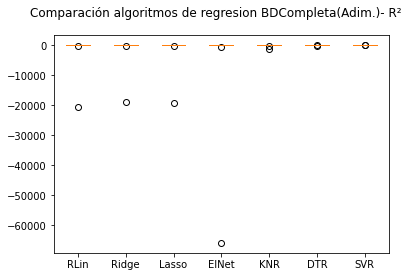

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDCompleta(Adim.)- R²")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDCompleta(Adim.)- R².jpg")

###MSE

In [ ]:
#Resumen parámetros
# métrica: MSE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_squared_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFAX,BDFAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-36,590,646,110,972.85%(104,851,987,727,359.78)
Ridge:-33,913,719,685,680.80%(96,813,958,136,540.20)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.13757e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.3712e-31): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.45941e-31): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.41641e-31): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditi

Lasso:-34,559,363,968,277.59%(98,727,121,681,204.44)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.962e+13, tolerance: 1.281e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.144e+13, tolerance: 1.325e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.575e+12, tolerance: 1.755e+09

ElNet:-114,147,770,070,955.17%(336,313,905,534,714.75)
KNR:-2,780,321,162,806.67%(5,054,930,298,850.44)
DTR:-2,016,118,568,266.64%(4,760,325,238,735.51)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-2,105,380,210,449.13%(5,345,056,089,277.97)


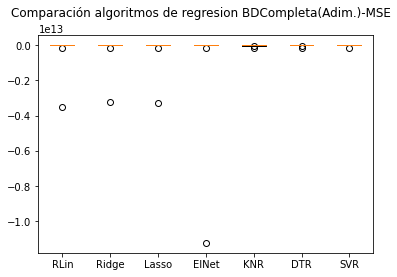

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDCompleta(Adim.)-MSE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDCompleta(Adim.)-MSE.jpg")

###MAE

In [ ]:
#Resumen parámetros
# métrica: MAE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_absolute_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFAX,BDFAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-5,985,475.55%(8,003,915.44)
Ridge:-5,906,273.29%(7,692,149.08)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.13757e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.3712e-31): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.45941e-31): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.41641e-31): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditi

Lasso:-5,920,103.21%(7,771,467.49)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.962e+13, tolerance: 1.281e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.144e+13, tolerance: 1.325e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.575e+12, tolerance: 1.755e+09

ElNet:-8,790,048.73%(14,487,014.37)
KNR:-4,465,917.18%(2,920,240.62)
DTR:-2,148,183.94%(2,524,152.89)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-2,896,910.24%(3,379,424.53)


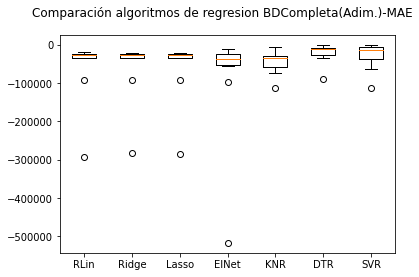

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDCompleta(Adim.)-MAE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDCompleta(Adim.)-MAE.jpg")

###2.4.2 Feature Selection

### Arboles de decision

In [ ]:
# Arboles de decisión
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#Generar la partición
X_train, X_test, Y_train, Y_test = train_test_split(BDFAX, BDFAY, test_size=0.33, random_state=7)
depth=3
tree=DecisionTreeRegressor(criterion='mse',max_depth=depth)
tree.fit(X_train,Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


DecisionTreeRegressor(criterion='mse', max_depth=3)

In [ ]:
subset=np.unique(tree.tree_.feature[tree.tree_.feature>=0])
print(f"Variables:{BDFAX.shape[1]}")
print(f"Variables utilizadas:{subset}")
print(f"Training: {tree.score(X_train,Y_train).round(2)}")
print(f"Test: {tree.score(X_test,Y_test).round(2)}")

Variables:13
Variables utilizadas:[ 2  4  6  8 12]
Training: 0.81
Test: 0.48


In [ ]:
print(BDFAX.columns[2],BDFAX.columns[4],BDFAX.columns[6],BDFAX.columns[8])

Ref EA Fr VCA


Se tiene que según el método árboles de decisión, las variables que aportan mas información al modelo corresponden a Reynolds del flujo(**Ref**), Esfuerzo aparente (**EA**), Número de Froude(**Fr**) y velocidad cortante adimensional(**VCA**).

In [ ]:
BDFAX

,AA,PA,Ref,Res,EA,Ff,Fr,CUA,VCA,TPA,CUA2,PM,Frp
0,2904.762,1248.571,116570.492,5.954,1.892,15.681,0.784,19579.134,0.318,0.053,7.252e+08,3.121,21.568
1,2904.762,1335.238,117442.623,5.776,1.780,15.229,0.714,20333.708,0.308,0.053,7.361e+08,2.938,20.319
2,2904.762,1132.381,93052.459,5.438,1.578,15.110,0.725,17109.968,0.290,0.053,4.621e+08,2.604,18.983
3,2904.762,1248.571,90219.672,4.910,1.286,14.718,0.607,18376.028,0.262,0.053,4.344e+08,2.123,16.693
4,2904.762,1132.381,81465.574,5.197,1.441,13.844,0.634,15676.523,0.277,0.053,3.542e+08,2.378,16.620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,2777.778,638.889,60000.000,8.111,0.697,11.578,0.491,7397.059,0.086,0.011,3.814e+07,1.150,9.666
7023,2777.778,511.111,59600.000,10.117,1.084,11.526,0.682,5891.302,0.107,0.011,3.763e+07,1.789,12.002
7024,2777.778,477.778,60800.000,7.522,0.599,16.918,0.770,8082.806,0.080,0.011,3.916e+07,0.989,13.098
7025,2777.778,222.222,37000.000,10.085,1.077,16.509,1.477,3668.764,0.107,0.011,1.450e+07,1.778,17.137


In [ ]:
BDFAY

,Phi
0,142350.418
1,87372.560
2,132884.068
3,75117.295
4,78112.223
...,...
7022,4832.932
7023,12085.794
7024,25867.800
7025,55523.139


###Eliminación Backward

In [ ]:
import statsmodels.api as sm

BDFAX_1=sm.add_constant(BDFAX)
model=sm.OLS(BDFAY,BDFAX_1).fit()
model.pvalues
# una variable con p mayor a 0.05 es candidata a eliminarse pues no añade información al modelo

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const     6.903e-35
AA        7.090e-09
PA        4.778e-95
Ref       7.139e-09
Res       7.297e-03
EA        1.322e-01
Ff        2.271e-04
Fr       8.030e-192
CUA       4.650e-01
VCA       0.000e+00
TPA       0.000e+00
CUA2      1.046e-05
PM        1.602e-08
Frp       1.058e-33
dtype: float64

Por tanto, según el método de eliminación Backward se considera que todas las variables aportan información al modelo menos  **EA** y **CUA**.

###Eliminación recursiva de características

In [ ]:
# Para aplicar la regresión logística se requiere e Label encoder para cambiar el dominio de la variables 0-1.
from sklearn import preprocessing
from sklearn import utils

lab = preprocessing.LabelEncoder()
BDFAY_t = lab.fit_transform(BDFAY)

#view transformed values
print(BDFAY_t)

[6137 5905 6106 ... 5272 5707 2893]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Eliminación recursiva de características
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model=LogisticRegression(solver='lbfgs',max_iter=1000)
rfe=RFE(model,n_features_to_select=4)  # dar prioridad a 4 variables
fit=rfe.fit(BDFAX,BDFAY_t)

print(list(BDFAX.columns))
print(f"Numero de  variables: {fit.n_features_}")
print(f"Variables seleccionadas: {fit.support_}")
print(f"Ranking de variables: {fit.ranking_}")

# Tarda mucho en aplicarse

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


### 2.4.3 Comparación de modelos Variables adimensionales reducidas

Tras la aplicación de los diferentes métodos se seleccionan  **Ref**,**EA**,**Fr** y **VCA** como las variables para la evaluación de los modelos.

In [ ]:
# X y Y reducidos
BDFARX=BDFA.drop(['AA','PA','Res','CUA','Ff','TPA','CUA2','Frp','PM','Phi'],axis='columns')
BDFARX

,Ref,EA,Fr,VCA
0,116570.492,1.892,0.784,0.318
1,117442.623,1.780,0.714,0.308
2,93052.459,1.578,0.725,0.290
3,90219.672,1.286,0.607,0.262
4,81465.574,1.441,0.634,0.277
...,...,...,...,...
7022,60000.000,0.697,0.491,0.086
7023,59600.000,1.084,0.682,0.107
7024,60800.000,0.599,0.770,0.080
7025,37000.000,1.077,1.477,0.107


In [ ]:
BDFAY

,Phi
0,142350.418
1,87372.560
2,132884.068
3,75117.295
4,78112.223
...,...
7022,4832.932
7023,12085.794
7024,25867.800
7025,55523.139


###R²

In [ ]:
#Resumen parámetros - Resultados 2e
# métrica_R²
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='r2'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFARX,BDFAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-4,287.09%(8,414.16)
Ridge:-4,285.28%(8,412.10)
Lasso:-4,286.92%(8,413.91)
ElNet:-2,068.33%(4,476.19)
KNR:-2,708.35%(6,038.02)
DTR:-408.31%(1,065.60)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-16.19%(19.26)


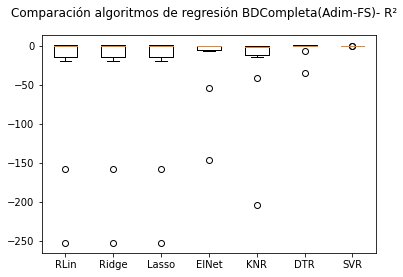

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresión BDCompleta(Adim-FS)- R²")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Regresion BDCompleta(Adim-FS)- R².jpg")

###MSE

In [ ]:
#Resumen parámetros
# métrica MSE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_squared_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFARX,BDFAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-2,159,795,500,567.46%(5,051,669,110,667.72)
Ridge:-2,159,408,195,819.26%(5,050,955,092,660.74)
Lasso:-2,159,641,179,504.99%(5,051,246,447,709.49)
ElNet:-1,997,145,871,609.07%(4,974,214,537,997.81)
KNR:-2,259,782,330,624.78%(5,136,711,247,171.43)
DTR:-1,806,437,029,437.76%(4,734,678,986,168.29)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-2,105,479,865,586.24%(5,345,109,471,905.94)


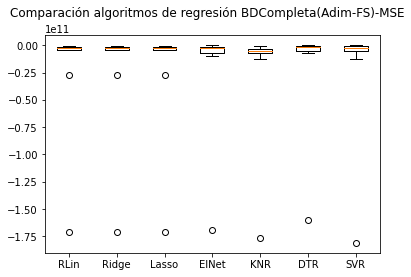

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresión BDCompleta(Adim-FS)-MSE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Regresion BDCompleta(Adim-FS)- MSE.jpg")

###MAE

In [ ]:
#Resumen parámetros
# métrica:mae
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_absolute_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFARX,BDFAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-3,628,871.49%(2,445,870.67)
Ridge:-3,627,695.94%(2,446,026.89)
Lasso:-3,628,746.69%(2,445,793.52)
ElNet:-3,664,656.50%(2,638,495.88)
KNR:-3,612,840.69%(2,723,439.56)
DTR:-1,891,572.66%(2,459,540.91)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-2,897,642.06%(3,379,712.85)


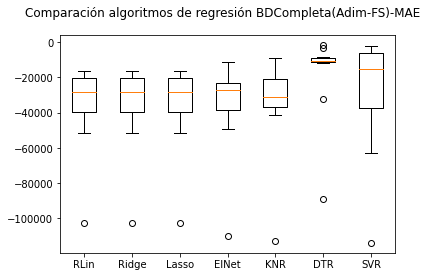

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresión BDCompleta(Adim-FS)-MAE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Regresion BDCompleta(Adim-FS)- MAE.jpg")

###2.4.4 Comparación de modelos - Variable adimensionales reducidas escaladas

###Escalamiento

In [ ]:
#escalamiento de la X a valores entre 0 y 1

#from sklearn.preprocessing import MinMaxScaler
#scaler=MinMaxScaler(feature_range=(0,1))
#rescaledX=scaler.fit_transform(BDFARX)
#np.set_printoptions(precision=3)
#print(rescaledX[0:5,:])

#estandarización de la X con media 0 y desviacion de 1
#from sklearn.preprocessing import StandardScaler
#scaler=StandardScaler().fit(BDFX)
#rescaledX=scaler.fit_transform(BDFX)
#np.set_printoptions(precision=3)
#print(rescaledX[0:5,:])

#normalizacion de la X a valores entre 0 y 1
from sklearn.preprocessing import Normalizer
scaler=Normalizer().fit(BDFX)
rescaledX=scaler.transform(BDFX)
np.set_printoptions(precision=3)
print(rescaledX[0:5,:])

[[0.014 0.121 0.992 0.042]
 [0.016 0.137 0.989 0.047]
 [0.012 0.131 0.99  0.045]
 [0.016 0.176 0.982 0.061]
 [0.012 0.144 0.988 0.049]]


###R²

In [ ]:
#Resumen parámetros - Resultados 2f
# métrica: r2
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='r2'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,rescaledX,BDFAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-954.77%(1,819.96)
Ridge:-958.09%(1,827.43)
Lasso:-954.90%(1,820.25)
ElNet:-910.94%(1,740.80)
KNR:-259.64%(702.63)
DTR:-136.99%(264.27)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-15.29%(19.07)


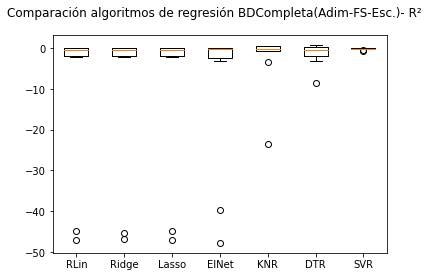

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresión BDCompleta(Adim-FS-Esc.)- R²")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Regresion BDCompleta(Adim-FS-Esc.)- R².jpg")

###MSE

In [ ]:
#Resumen parámetros
# métrica MSE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_squared_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,rescaledX,BDFAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-1,991,899,285,985.06%(5,120,129,216,574.50)
Ridge:-1,991,455,290,800.19%(5,120,173,914,059.24)
Lasso:-1,991,876,881,203.21%(5,120,114,274,923.48)
ElNet:-2,028,953,349,463.17%(5,210,438,757,075.02)
KNR:-1,863,341,485,406.34%(4,977,922,516,573.83)
DTR:-1,528,921,038,423.57%(3,965,563,307,043.11)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-2,102,720,082,229.96%(5,342,697,892,988.30)


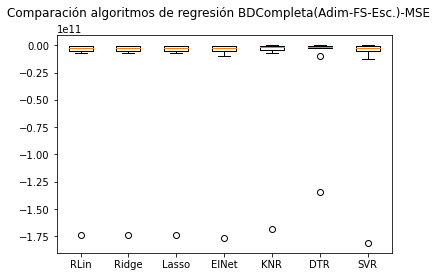

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresión BDCompleta(Adim-FS-Esc.)-MSE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Regresion BDCompleta(Adim-FS-Esc.)- MSE.jpg")

###MAE

In [ ]:
#Resumen parámetros
# métrica:mae
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_absolute_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,rescaledX,BDFAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-4,275,791.59%(2,519,633.85)
Ridge:-4,272,949.58%(2,519,229.17)
Lasso:-4,275,752.87%(2,519,575.67)
ElNet:-4,172,435.79%(2,648,865.97)
KNR:-2,460,135.62%(2,729,817.43)
DTR:-2,285,971.11%(2,559,773.09)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-2,874,192.07%(3,371,983.96)


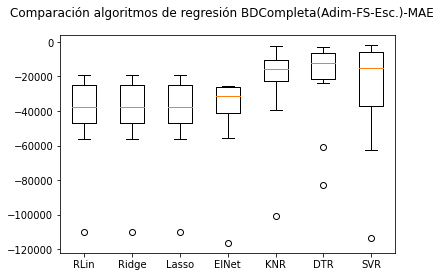

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresión BDCompleta(Adim-FS-Esc.)-MAE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Regresion BDCompleta(Adim-FS-Esc.)- MAE.jpg")

#3.OPTIMIZACION DE HIPERPARÁMETROS

##3.1 GridSearchCV

In [ ]:
# Cargue de bibliotecas para la bùsqueda de hiperparámetros óptimos
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

#Selección del estimador 
estimador_RF=RandomForestClassifier()

In [ ]:
#Visualización de parámetros del modelo Random Forest
estimador_RF.get_params()

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}

In [ ]:
parametros_busqueda_RF={"criterion":["gini","entropy"],"n_estimators":np.linspace(10,1000,10).astype(int),"class_weight":[None,"balanced"]}

In [ ]:
grid.fit(rescaledX,BDFAY)

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

Los mejores hiperparámetros fueron:

In [ ]:
#Orden de resultados
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')

### Modelo óptimo

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(rescaledX,BDFAY,test_size=0.3)
clasificador_knn=KNeighborsClassifier(leaf_size=1, metric="minkowski", n_neighbors=5, p=1, weights="distance")
clasificador_knn.fit(X_train,y_train)

In [ ]:
Ypred_knn=clasificador_knn.predict(BDCBX)
Ypred_knn

In [ ]:
y3 = pd.DataFrame(Ypred_knn,columns=column_names) # convertir array a dataframe

ycomp= pd.DataFrame() # crear dataframe con los dos valors de y
ycomp['y_pred']=y3
ycomp['y_prueb']=BDCBY

ycomp = ycomp.astype(float) # convertir de enteros a flotantes

plt.plot(ycomp['y_pred'],ycomp['y_prueb']) # Graficar
plt.show()

###RandomizedSearch

In [ ]:
busqueda_random=RandomizedSearchCV(estimator=estimador_RF,
                                   param_distributions=parametros_busqueda_RF,
                                   scoring="roc_auc",n_jobs=-1,n_iter=15)

In [ ]:
resultados["RF_gridsearch"]=evaluar_modelo(grid.best_estimator_,rescaledX,BDFAY)

In [ ]:
busqueda_random.fit(rescaledX,BDFAY)

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

In [ ]:
#Orden de resultados
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')